## EDA

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from collections import Counter


import optuna
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [50]:
df_train = pd.read_csv('Downloads/playground-series-s4e1/train.csv')
df_test = pd.read_csv('Downloads/playground-series-s4e1/test.csv')

In [51]:
print(f'df_train: {df_train.shape}')
print(f'df_test: {df_test.shape}')

df_train: (165034, 14)
df_test: (110023, 13)


In [52]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [53]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


In [56]:
df_train.isnull().sum().sort_values(ascending=False) # проверяем пропуски

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [57]:
df_test.isnull().sum().sort_values(ascending=False)

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

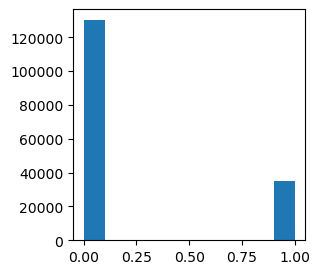

In [59]:
plt.figure(figsize=(3,3))
plt.hist(df_train['Exited']);

In [60]:
df_target = df_train[['Exited']]
df_train = df_train.drop('Exited', axis=1)

In [61]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275052,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
275053,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
275054,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
275055,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


#### Categorical Features Encoding

In [62]:
df_all['Gender'] = np.where(df_all['Gender']=='Male', 1, 0)

In [63]:
df_all = df_all.drop(['id', 'CustomerId', 'Surname'], axis=1)
df_all.shape

(275057, 10)

In [201]:
te = TargetEncoder()

In [65]:
X = ['Geography']
df_for_te = df_all.loc[:len(df_target) - 1]
df_for_te.loc[:, X] = te.fit_transform(df_for_te.select_dtypes(include='object'), df_target['Exited'])

df_for_te1 = df_all.loc[len(df_target):]
df_for_te1.loc[:, X] = te.transform(df_for_te1.select_dtypes(include='object'))

df_all = pd.concat([df_for_te, df_for_te1], axis=0)

In [66]:
df_all.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,0.165282,1,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,0.165282,1,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,0.165282,1,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,0.165282,1,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,0.172176,1,33.0,5,0.00,2,1.0,1.0,15068.83


#### Feature Selection

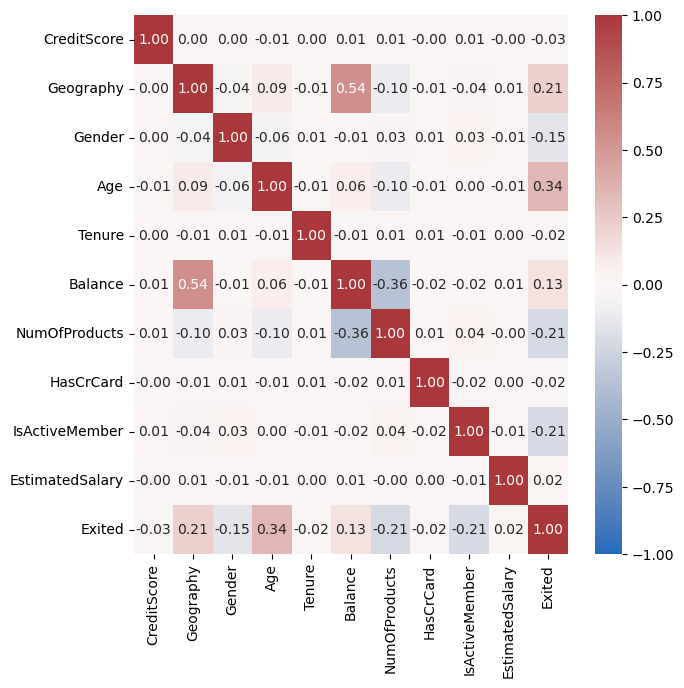

In [67]:
plt.figure(figsize=(7,7))
sns.heatmap(pd.concat([df_for_te, df_target], axis=1).corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='vlag');

In [69]:
df_tt = df_all.loc[:len(df_target) - 1]
for feature in df_tt.columns.to_list():
    df_target_reset = df_target.reset_index(drop=True)
    
    group1 = df_tt.loc[df_target_reset['Exited'] == 0, feature] 
    group2 = df_tt.loc[df_target_reset['Exited'] == 1, feature]

    # t-test
    t_statistic, p_value = ttest_ind(group1, group2) 
    print(f"{feature} t-statistic: {t_statistic}, p_value: {p_value}")

CreditScore t-statistic: 11.128116005299207, p_value: 9.373557251570065e-29
Geography t-statistic: -87.76108566472874, p_value: 0.0
Gender t-statistic: 60.13894895537367, p_value: 0.0
Age t-statistic: -147.2472403347262, p_value: 0.0
Tenure t-statistic: 7.949569632427535, p_value: 1.8833179416314184e-15
Balance t-statistic: -53.156202840957384, p_value: 0.0
NumOfProducts t-statistic: 89.23898211813093, p_value: 0.0
HasCrCard t-statistic: 8.996929690879403, p_value: 2.3448985513035113e-19
IsActiveMember t-statistic: 87.35940814380538, p_value: 0.0
EstimatedSalary t-statistic: -7.649581965635489, p_value: 2.027177371186941e-14


p-value достаточно низкий для всех признаков: все фичи важны

#### Oversampling & Undersampling

In [70]:
df_train = df_all.loc[:len(df_target) - 1] # разделяем выборки
df_test = df_all.loc[len(df_target):]

In [71]:
tl = TomekLinks(sampling_strategy='majority') 
df_train, df_target = tl.fit_resample(df_train, df_target)
print('Resampled dataset shape %s' % Counter(df_target))

Resampled dataset shape Counter({'Exited': 1})


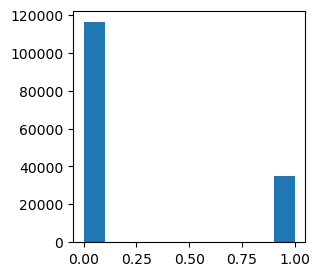

In [72]:
plt.figure(figsize=(3,3))
plt.hist(df_target['Exited']);

In [77]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(df_train, df_target)

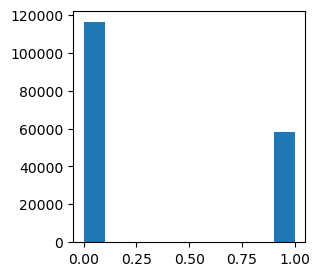

In [78]:
plt.figure(figsize=(3,3))
plt.hist(y_resampled_smote['Exited']);

In [81]:
sampler = RandomUnderSampler(sampling_strategy={0:100000}, random_state=42)
df_train_rs, df_target_rs = sampler.fit_resample(X_resampled_smote, y_resampled_smote)

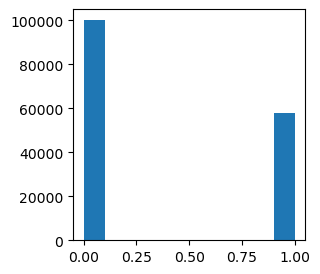

In [82]:
plt.figure(figsize=(3,3))
plt.hist(df_target_rs['Exited']);

In [88]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train_rs, df_target_rs, test_size=0.2, random_state=42)

In [89]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [90]:
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
df_test = scaler.transform(df_test)

### Logistic Regression

In [111]:
def objective(trial):
    param = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'max_iter': 1000,
        'random_state': 42,
    }

    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    
    preds = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    
    return roc_auc

study = optuna.create_study(direction='maximize')

for _ in tqdm(range(10), desc="Optimizing Hyperparameters"):
    study.optimize(objective, n_trials=1, n_jobs=1)

best_params_lr = study.best_params
print("Best hyperparameters:", best_params_lr)
print("ROC AUC: {}".format(study.best_value))

[I 2024-12-04 00:24:04,336] A new study created in memory with name: no-name-81c9d0dd-2da8-479f-8b0f-5b9441ebf150
Optimizing Hyperparameters: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

Best hyperparameters: {'C': 56.36809776160641}
ROC AUC: 0.8528896832555449


In [112]:
logreg = LogisticRegression(**best_params_lr)
logreg.fit(X_train, y_train)

LogisticRegression(C=56.36809776160641)

In [113]:
y_train_pred_lr = logreg.predict_proba(X_train)
y_test_pred_lr = logreg.predict_proba(X_valid)
print("ROC-AUC on train set:", roc_auc_score(y_train['Exited'].values, y_train_pred_lr[:, 1]))
print("ROC-AUC on test set:", roc_auc_score(y_valid['Exited'].values, y_test_pred_lr[:, 1]))

ROC-AUC on train set: 0.8536551372350552
ROC-AUC on test set: 0.8528896832555449


In [114]:
df_test_pred_lr = logreg.predict_proba(df_test)
prediction_lr = pd.concat([ids, pd.DataFrame(df_test_pred_lr[:, 1], columns=['Exited'])], axis=1)
prediction_lr.to_csv('churn_submission_lr1.csv', index=False)

### Catboost

In [94]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10)
    }

    model = CatBoostClassifier(
        **param,
        eval_metric='AUC',
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=0)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    
    return roc_auc

study = optuna.create_study(direction='maximize')

for _ in tqdm(range(20), desc="Optimizing Hyperparameters"):
    study.optimize(objective, n_trials=1, n_jobs=1)

best_params_catboost = study.best_params
print("Best hyperparameters:", best_params_catboost)
print("ROC AUC: {}".format(study.best_value))

[I 2024-12-03 23:35:36,747] A new study created in memory with name: no-name-9200c0f4-e720-48cc-ab25-86adf7f34b9a
Optimizing Hyperparameters:  75%|███████▌  | 15/20 [06:37<04:06, 49.39s/it]Training has stopped (degenerate solution on iteration 128, probably too small l2-regularization, try to increase it)
[I 2024-12-03 23:42:18,486] Trial 15 finished with value: 0.9272196617532319 and parameters: {'iterations': 1741, 'depth': 6, 'learning_rate': 0.026198609538398678, 'l2_leaf_reg': 0.00025039128798506915}. Best is trial 13 with value: 0.932188268740023.
Optimizing Hyperparameters: 100%|██████████| 20/20 [09:44<00:00, 29.21s/it]

Best hyperparameters: {'iterations': 1845, 'depth': 7, 'learning_rate': 0.02561316392658992, 'l2_leaf_reg': 0.00010330607323872993}
ROC AUC: 0.932188268740023


In [96]:
cat = CatBoostClassifier(**best_params_catboost, eval_metric='AUC', verbose=0, random_state=42)
cat.fit(X_train, y_train, verbose=0)

In [99]:
y_train_pred_cat = cat.predict_proba(X_train)
y_test_pred_cat = cat.predict_proba(X_valid)
print("ROC-AUC on train set:", roc_auc_score(y_train['Exited'].values, y_train_pred_cat[:, 1]))
print("ROC-AUC on test set:", roc_auc_score(y_valid['Exited'].values, y_test_pred_cat[:, 1]))

ROC-AUC on train set: 0.9499739869811037
ROC-AUC on test set: 0.9324947290625715


In [100]:
ids = pd.read_csv('Downloads/playground-series-s4e1/test.csv')['id']

In [101]:
df_test_pred_cat = cat.predict_proba(df_test)
prediction_cat = pd.concat([ids, pd.DataFrame(df_test_pred_cat[:, 1], columns=['Exited'])], axis=1)
prediction_cat.to_csv('churn_submission_cat1.csv', index=False)

### Random Forest

In [103]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    
    preds = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    
    return roc_auc

study = optuna.create_study(direction='maximize')

for _ in tqdm(range(20), desc="Optimizing Hyperparameters"):
    study.optimize(objective, n_trials=1, n_jobs=1)

best_params_RF = study.best_params
print("Best hyperparameters:", best_params_RF)
print("ROC AUC: {}".format(study.best_value))

[I 2024-12-04 00:00:25,720] A new study created in memory with name: no-name-6b3b1734-0733-412d-ae35-b8a5abcb4219
Optimizing Hyperparameters:  15%|█▌        | 3/20 [13:04<1:15:15, 265.62s/it][W 2024-12-04 00:13:40,879] Trial 3 failed with parameters: {'n_estimators': 616, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\annba\AppData\Local\Temp\ipykernel_18020\2599877599.py", line 13, in objective
    model.fit(X_train, y_train)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 489, in fit
    trees = Parallel(
  File "D:\Anaconda\

KeyboardInterrupt: 

In [104]:
best_params_RF = {'n_estimators': 494, 
                  'max_depth': 26, 
                  'min_samples_split': 20, 
                  'min_samples_leaf': 7, 
                  'max_features': 'log2', 
                  'bootstrap': False, 
                  'criterion': 'entropy',
                  'random_state': 42}

In [106]:
rf_model = RandomForestClassifier(**best_params_RF)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=26,
                       max_features='log2', min_samples_leaf=7,
                       min_samples_split=20, n_estimators=494, random_state=42)

In [107]:
y_train_pred_rf = rf_model.predict_proba(X_train)
y_test_pred_rf = rf_model.predict_proba(X_valid)
print("ROC-AUC on train set:", roc_auc_score(y_train['Exited'].values, y_train_pred_rf[:, 1]))
print("ROC-AUC on test set:", roc_auc_score(y_valid['Exited'].values, y_test_pred_rf[:, 1]))

ROC-AUC on train set: 0.9784391773434948
ROC-AUC on test set: 0.9265282948134236


In [109]:
df_test_pred_rf = rf_model.predict_proba(df_test)
prediction_rf = pd.concat([ids, pd.DataFrame(df_test_pred_rf[:, 1], columns=['Exited'])], axis=1)
prediction_rf.to_csv('churn_submission_rf1.csv', index=False)

### XGBoost

In [116]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='auc', random_state=42)
    model.fit(X_train, y_train)
    
    preds = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)
    
    return roc_auc

study = optuna.create_study(direction='maximize')

for _ in tqdm(range(30), desc="Optimizing Hyperparameters"):
    study.optimize(objective, n_trials=1, n_jobs=1)

best_params_XGBC = study.best_params
print("Best hyperparameters:", best_params_XGBC)
print("ROC AUC: {}".format(study.best_value))

[I 2024-12-04 00:29:38,732] A new study created in memory with name: no-name-5c5d8403-6e86-4a6f-91da-863745813a70
Optimizing Hyperparameters: 100%|██████████| 30/30 [02:41<00:00,  5.39s/it]

Best hyperparameters: {'n_estimators': 572, 'learning_rate': 0.04810958286222563, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8684949365017075, 'colsample_bytree': 0.7904695570439749, 'gamma': 1.2856553892297928e-08, 'reg_alpha': 9.289370077829562e-08, 'reg_lambda': 0.0008212418757246874}
ROC AUC: 0.9304593903705655


In [30]:
# best_params_XGBC = {'n_estimators': 879, 'learning_rate': 0.03525886871357374, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5273764834794987, 'colsample_bytree': 0.5481388610405683, 'gamma': 3.670246008108452e-05, 'reg_alpha': 0.46510044957986735, 'reg_lambda': 0.4539495539992052}

In [117]:
xgb_model = XGBClassifier(**best_params_XGBC)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7904695570439749, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=1.2856553892297928e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04810958286222563, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=572, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [118]:
y_train_pred_xgb = xgb_model.predict_proba(X_train)
y_test_pred_xgb = xgb_model.predict_proba(X_valid)
print("ROC-AUC on train set:", roc_auc_score(y_train['Exited'].values, y_train_pred_xgb[:, 1]))
print("ROC-AUC on test set:", roc_auc_score(y_valid['Exited'].values, y_test_pred_xgb[:, 1]))

ROC-AUC on train set: 0.9398518917727708
ROC-AUC on test set: 0.9303974786094897


In [119]:
df_test_pred_xgb = xgb_model.predict_proba(df_test)
prediction_xgb = pd.concat([ids, pd.DataFrame(df_test_pred_xgb[:, 1], columns=['Exited'])], axis=1)
prediction_xgb.to_csv('churn_submission_xgb1.csv', index=False)

### Stacking

In [122]:
base_models = [
    ('cat', CatBoostClassifier(**best_params_catboost, eval_metric='AUC', verbose=0, random_state=42)),
    ('gb', RandomForestClassifier(**best_params_RF)),
    ('xgb', XGBClassifier(**best_params_XGBC)),
]

meta_model = LogisticRegression(**best_params_lr, random_state=42)

In [123]:
stacking_clf = StackingClassifier(
    estimators=base_models,  
    final_estimator=meta_model, 
    cv=5, 
    passthrough=False,
    n_jobs=-1
)

In [124]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001D5A6305040>),
                               ('gb',
                                RandomForestClassifier(bootstrap=False,
                                                       criterion='entropy',
                                                       max_depth=26,
                                                       max_features='log2',
                                                       min_samples_leaf=7,
                                                       min_samples_split=20,
                                                       n_estimators=494,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsamp...
                                              learning_rate=0.04810958286222563,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=7, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=572, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(C=56.36809776160641,
                                                      random_state=42),
                   n_jobs=-1)

In [125]:
y_train_pred_stacking = stacking_clf.predict_proba(X_train)
y_test_pred_stacking = stacking_clf.predict_proba(X_valid)
print("ROC-AUC on train set:", roc_auc_score(y_train['Exited'].values, y_train_pred_stacking[:, 1]))
print("ROC-AUC on test set:", roc_auc_score(y_valid['Exited'].values, y_test_pred_stacking[:, 1]))

ROC-AUC on train set: 0.953275691878119
ROC-AUC on test set: 0.9327824055030496


In [126]:
df_test_pred_stacking = stacking_clf.predict_proba(df_test)
prediction_stacking = pd.concat([ids, pd.DataFrame(df_test_pred_stacking[:, 1], columns=['Exited'])], axis=1)
prediction_stacking.to_csv('churn_submission_stacking1.csv', index=False)